In [1]:
import os
import sys
sys.dont_write_bytecode = True

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm

log_dir = "logs"
models = ["hmm-ord1", "hmm-neural", "hmm-ord2", "dmm", "nhmm-train", "nhmm-stock", "arm", "tcm"]
seeds = range(5)
methods = ["seq", "plate", "vmarkov", "discHMM", "manual", "ours"]
measures = ["time", "memory"]
num_step = 1000

# model -> seed -> method -> measure -> data
data = {}
for model in models:
    data_model = {}
    for seed in seeds:
        data_seed = {}
        for method in methods:
            data_method = {}
            for measure in measures:
                try:
                    data_method[measure] = pd.read_csv(os.path.join(log_dir, f"{model}-{method}-seed{seed}-performance.log"),
                                                       usecols=["total", "guide", "model", "reduce", "backward"] if measure == "time" else ["memory"])
                except:
                    data_method[measure] = pd.DataFrame(np.nan, index=np.arange(num_step),
                                                        columns=["total", "guide", "model", "reduce", "backward"] if measure == "time" else ["memory"])
            data_seed[method] = data_method
        data_model[seed] = data_seed
    data[model] = data_model

In [2]:
dfs = []
dfs_std = []  # standard deviation
dfs_low = []  # lower bound of 95% confidence interval
dfs_high = []  # upper bound of 95% confidence interval

for method in methods:
    dfs_method = []
    dfs_std_method = []
    dfs_low_method = []
    dfs_high_method = []

    for part in ["model", "total"]:
        times = {}
        for model in models:
            time = []
            for seed in seeds:
                burn_in = 1 if method == "seq" else 10
                time.append(data[model][seed][method]["time"][part].to_numpy()[burn_in:])
            times[model] = np.concatenate(time)

        times_mean = {model: np.mean(times[model]) for model in times}
        times_std = {model: np.std(times[model]) for model in times}
        times_low = {model: np.percentile(times[model], 2.5) for model in times}
        times_high = {model: np.percentile(times[model], 97.5) for model in times}

        df_mean = pd.DataFrame(times_mean.items(), columns=["Benchmark", "mean"])
        df_std = pd.DataFrame(times_std.items(), columns=["Benchmark", "std"])
        df_low = pd.DataFrame(times_low.items(), columns=["Benchmark", "low"])
        df_high = pd.DataFrame(times_high.items(), columns=["Benchmark", "high"])

        df_mean.set_index("Benchmark", inplace=True)
        df_std.set_index("Benchmark", inplace=True)
        df_low.set_index("Benchmark", inplace=True)
        df_high.set_index("Benchmark", inplace=True)

        dfs_method.append(df_mean)
        dfs_std_method.append(df_std)
        dfs_low_method.append(df_low)
        dfs_high_method.append(df_high)
    
    dfs.append(pd.concat(dfs_method, axis=1))
    dfs_std.append(pd.concat(dfs_std_method, axis=1))
    dfs_low.append(pd.concat(dfs_low_method, axis=1))
    dfs_high.append(pd.concat(dfs_high_method, axis=1))

print("Averaged time per epoch (s)")
time = pd.concat(dfs, axis=1)
time.columns = pd.MultiIndex.from_product([["seq", "plate", "vmarkov", "discHMM", "manual", "ours"] , ["score", "total"]])
time.index = models
display(time.round(3))

print("Speedups of ours over others")
time_ratio = pd.concat([dfs[0] / dfs[5], dfs[1] / dfs[5], dfs[2] / dfs[5], dfs[3] / dfs[5], dfs[4] / dfs[5]], axis=1)
time_ratio.columns = pd.MultiIndex.from_product([["seq -> ours", "plate -> ours", "vmarkov -> ours", "discHMM -> ours", "manual -> ours"] , ["score", "total"]])
time_ratio.index = models
display(time_ratio.round(1))

print("Std of time per epoch (s)")
time_std = pd.concat(dfs_std, axis=1)
time_std.columns = pd.MultiIndex.from_product([["seq", "plate", "vmarkov", "discHMM", "manual", "ours"] , ["score", "total"]])
time_std.index = models
display(time_std.round(3))

time_low = pd.concat(dfs_low, axis=1)
time_low.columns = pd.MultiIndex.from_product([["seq", "plate", "vmarkov", "discHMM", "manual", "ours"] , ["score", "total"]])
time_low.index = models
time_high = pd.concat(dfs_high, axis=1)
time_high.columns = pd.MultiIndex.from_product([["seq", "plate", "vmarkov", "discHMM", "manual", "ours"] , ["score", "total"]])
time_high.index = models


def swap_column_levels(df):
    df_result = pd.DataFrame()
    for measure in ["score", "total"]:
        df_measure = pd.DataFrame()
        for method in ["seq", "plate", "vmarkov", "discHMM", "manual", "ours"]:
            df_measure = pd.concat([df_measure, df[(method, measure)]], axis=1)
        df_measure.columns = pd.MultiIndex.from_product([[measure], ["seq", "plate", "vmarkov", "discHMM", "manual", "ours"]])
        df_result = pd.concat([df_result, df_measure], axis=1)

    return df_result

print(swap_column_levels(time_std).to_latex(formatters=[lambda x: f"{x:.3f}"]*len(time_std.columns), na_rep="-", bold_rows=True))

Averaged time per epoch (s)


seq             plate         vmarkov        discHMM         \
              score     total   score   total   score  total   score  total   
hmm-ord1    669.097  1066.060   0.118   0.192   0.054  0.083   0.006  0.018   
hmm-neural   35.715    60.474   0.158   0.275   0.056  0.082   0.010  0.027   
hmm-ord2    131.594   205.457   0.124   0.282   0.165  0.280     NaN    NaN   
dmm          42.092   129.339   0.199   0.957   0.076  0.524     NaN    NaN   
nhmm-train   91.287   121.993  18.523  25.021     NaN    NaN     NaN    NaN   
nhmm-stock   29.925    57.417   3.058   6.247     NaN    NaN     NaN    NaN   
arm           1.129     2.354     NaN     NaN   0.177  0.199     NaN    NaN   
tcm           1.653     3.837     NaN     NaN     NaN    NaN     NaN    NaN   

           manual          ours         
            score  total  score  total  
hmm-ord1    0.006  0.035  0.021  0.075  
hmm-neural  0.009  0.042  0.028  0.062  
hmm-ord2    0.009  0.127  0.027  0.158  
dmm         0.004  0.427  0.016  0.496  
nhmm-train  0.015  0.198  0.127  0.319  
nhmm-stock  0.005  0.022  0.089  0.139  
arm         0.003  0.009  0.031  0.043  
tcm           NaN    NaN  0.029  0.045

Speedups of ours over others


seq -> ours          plate -> ours       vmarkov -> ours        \
                 score    total         score total           score total   
hmm-ord1       31399.3  14302.9           5.6   2.6             2.6   1.1   
hmm-neural      1291.6    972.4           5.7   4.4             2.0   1.3   
hmm-ord2        4824.4   1300.4           4.5   1.8             6.0   1.8   
dmm             2657.3    260.7          12.6   1.9             4.8   1.1   
nhmm-train       718.5    382.2         145.8  78.4             NaN   NaN   
nhmm-stock       337.0    414.1          34.4  45.1             NaN   NaN   
arm               36.2     54.8           NaN   NaN             5.7   4.6   
tcm               57.7     85.6           NaN   NaN             NaN   NaN   

           discHMM -> ours       manual -> ours        
                     score total          score total  
hmm-ord1               0.3   0.2            0.3   0.5  
hmm-neural             0.4   0.4            0.3   0.7  
hmm-ord2               NaN   NaN            0.3   0.8  
dmm                    NaN   NaN            0.3   0.9  
nhmm-train             NaN   NaN            0.1   0.6  
nhmm-stock             NaN   NaN            0.1   0.2  
arm                    NaN   NaN            0.1   0.2  
tcm                    NaN   NaN            NaN   NaN

Std of time per epoch (s)


seq          plate        vmarkov        discHMM        manual  \
             score   total  score  total   score  total   score  total  score   
hmm-ord1    53.727  50.168  0.018  0.018   0.004  0.005     0.0  0.001  0.000   
hmm-neural   0.387   3.242  0.005  0.019   0.004  0.005     0.0  0.001  0.000   
hmm-ord2     1.919   2.344  0.019  0.021   0.008  0.010     NaN    NaN  0.000   
dmm          0.555   9.477  0.031  0.046   0.002  0.009     NaN    NaN  0.000   
nhmm-train   1.036   1.132  0.223  0.234     NaN    NaN     NaN    NaN  0.000   
nhmm-stock   2.025   2.498  0.056  0.076     NaN    NaN     NaN    NaN  0.000   
arm          0.064   0.143    NaN    NaN   0.065  0.066     NaN    NaN  0.001   
tcm          0.064   0.220    NaN    NaN     NaN    NaN     NaN    NaN    NaN   

                    ours         
            total  score  total  
hmm-ord1    0.001  0.001  0.002  
hmm-neural  0.001  0.001  0.002  
hmm-ord2    0.008  0.000  0.005  
dmm         0.004  0.000  0.005  
nhmm-train  0.003  0.001  0.003  
nhmm-stock  0.002  0.001  0.002  
arm         0.001  0.010  0.010  
tcm           NaN  0.000  0.000

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{6}{r}{score} & \multicolumn{6}{r}{total} \\
 & seq & plate & vmarkov & discHMM & manual & ours & seq & plate & vmarkov & discHMM & manual & ours \\
\midrule
\textbf{hmm-ord1} & 53.727 & 0.018 & 0.004 & 0.000 & 0.000 & 0.001 & 50.168 & 0.018 & 0.005 & 0.001 & 0.001 & 0.002 \\
\textbf{hmm-neural} & 0.387 & 0.005 & 0.004 & 0.000 & 0.000 & 0.001 & 3.242 & 0.019 & 0.005 & 0.001 & 0.001 & 0.002 \\
\textbf{hmm-ord2} & 1.919 & 0.019 & 0.008 & - & 0.000 & 0.000 & 2.344 & 0.021 & 0.010 & - & 0.008 & 0.005 \\
\textbf{dmm} & 0.555 & 0.031 & 0.002 & - & 0.000 & 0.000 & 9.477 & 0.046 & 0.009 & - & 0.004 & 0.005 \\
\textbf{nhmm-train} & 1.036 & 0.223 & - & - & 0.000 & 0.001 & 1.132 & 0.234 & - & - & 0.003 & 0.003 \\
\textbf{nhmm-stock} & 2.025 & 0.056 & - & - & 0.000 & 0.001 & 2.498 & 0.076 & - & - & 0.002 & 0.002 \\
\textbf{arm} & 0.064 & - & 0.065 & - & 0.001 & 0.010 & 0.143 & - & 0.066 & - & 0.001 & 0.010 \\
\textbf{tcm} & 0.064 & - & - & - &

In [3]:
dfs = []
dfs_std = []
dfs_low = []
dfs_high = []

for method in methods:
    memories = {}
    for model in models:
        memory = []
        for seed in seeds:
            memory.append(data[model][seed][method]["memory"]["memory"].to_numpy() / (10 ** 9))
        memories[model] = np.concatenate(memory)

    memory_means = {model: np.mean(memories[model]) for model in memories}
    memory_stds = {model: np.std(memories[model]) for model in memories}
    memory_lows = {model: np.percentile(memories[model], 2.5) for model in memories}
    memory_highs = {model: np.percentile(memories[model], 97.5) for model in memories}

    df_memory = pd.DataFrame(memory_means.items(), columns=["Benchmark", "Memory"])
    df_memory_std = pd.DataFrame(memory_stds.items(), columns=["Benchmark", "Memory std"])
    df_memory_low = pd.DataFrame(memory_lows.items(), columns=["Benchmark", "Memory low"])
    df_memory_high = pd.DataFrame(memory_highs.items(), columns=["Benchmark", "Memory high"])

    df_memory.set_index("Benchmark", inplace=True)
    df_memory_std.set_index("Benchmark", inplace=True)
    df_memory_low.set_index("Benchmark", inplace=True)
    df_memory_high.set_index("Benchmark", inplace=True)

    dfs.append(df_memory)
    dfs_std.append(df_memory_std)
    dfs_low.append(df_memory_low)
    dfs_high.append(df_memory_high)

print("Maximum memory usage (GB)")
memory = pd.concat(dfs, axis=1)
memory.columns = ["seq", "plate", "vmarkov", "discHMM", "manual", "ours"]
memory.index = models
display(memory.round(3))

print("Ratio of maximum memory usage")
memory_ratio = pd.concat([dfs[0] / dfs[5], dfs[1] / dfs[5], dfs[2] / dfs[5], dfs[3] / dfs[5], dfs[4] / dfs[5]], axis=1)
memory_ratio.columns = ["seq / ours", "plate / ours", "vmarkov / ours", "discHMM / ours", "manual / ours"]
memory_ratio.index = models
display(memory_ratio.round(2))

print("Std of maximum memory usage (GB)")
memory_std = pd.concat(dfs_std, axis=1)
memory_std.columns = ["seq", "plate", "vmarkov", "discHMM", "manual", "ours"]
memory_std.index = models
display(memory_std.round(3))

memory_low = pd.concat(dfs_low, axis=1)
memory_low.columns = ["seq", "plate", "vmarkov", "discHMM", "manual", "ours"]
memory_low.index = models
memory_high = pd.concat(dfs_high, axis=1)
memory_high.columns = ["seq", "plate", "vmarkov", "discHMM", "manual", "ours"]
memory_high.index = models


print(memory_ratio.to_latex(formatters=[lambda x: f"{x:.3f}"]*len(time_std.columns), na_rep="-", bold_rows=True))

Maximum memory usage (GB)


,seq,plate,vmarkov,discHMM,manual,ours
hmm-ord1,5.053,0.700,1.582,0.277,0.888,1.774
hmm-neural,0.723,0.518,1.300,0.483,1.002,1.043
hmm-ord2,1.902,0.868,5.229,NaN,2.289,2.467
dmm,0.871,0.622,1.201,NaN,0.679,0.739
nhmm-train,3.342,2.851,NaN,NaN,3.899,3.989
nhmm-stock,0.260,0.057,NaN,NaN,0.039,0.040
arm,0.015,NaN,0.011,NaN,0.000,0.002
tcm,0.022,NaN,NaN,NaN,NaN,0.001


Ratio of maximum memory usage


,seq / ours,plate / ours,vmarkov / ours,discHMM / ours,manual / ours
hmm-ord1,2.85,0.39,0.89,0.16,0.50
hmm-neural,0.69,0.50,1.25,0.46,0.96
hmm-ord2,0.77,0.35,2.12,NaN,0.93
dmm,1.18,0.84,1.63,NaN,0.92
nhmm-train,0.84,0.71,NaN,NaN,0.98
nhmm-stock,6.49,1.42,NaN,NaN,0.96
arm,9.84,NaN,7.31,NaN,0.19
tcm,28.87,NaN,NaN,NaN,NaN


Std of maximum memory usage (GB)


,seq,plate,vmarkov,discHMM,manual,ours
hmm-ord1,0.000,0.000,0.000,0.0,0.000,0.000
hmm-neural,0.000,0.000,0.000,0.0,0.000,0.000
hmm-ord2,0.000,0.000,0.000,NaN,0.000,0.000
dmm,0.006,0.001,0.001,NaN,0.001,0.001
nhmm-train,0.003,0.000,NaN,NaN,0.000,0.000
nhmm-stock,0.001,0.000,NaN,NaN,0.000,0.000
arm,0.000,NaN,0.001,NaN,0.000,0.000
tcm,0.000,NaN,NaN,NaN,NaN,0.000


\begin{tabular}{lrrrrr}
\toprule
 & seq / ours & plate / ours & vmarkov / ours & discHMM / ours & manual / ours \\
\midrule
\textbf{hmm-ord1} & 2.849 & 0.395 & 0.892 & 0.156 & 0.501 \\
\textbf{hmm-neural} & 0.693 & 0.496 & 1.246 & 0.463 & 0.961 \\
\textbf{hmm-ord2} & 0.771 & 0.352 & 2.120 & - & 0.928 \\
\textbf{dmm} & 1.179 & 0.841 & 1.626 & - & 0.919 \\
\textbf{nhmm-train} & 0.838 & 0.715 & - & - & 0.977 \\
\textbf{nhmm-stock} & 6.487 & 1.420 & - & - & 0.963 \\
\textbf{arm} & 9.842 & - & 7.313 & - & 0.193 \\
\textbf{tcm} & 28.872 & - & - & - & - \\
\bottomrule
\end{tabular}



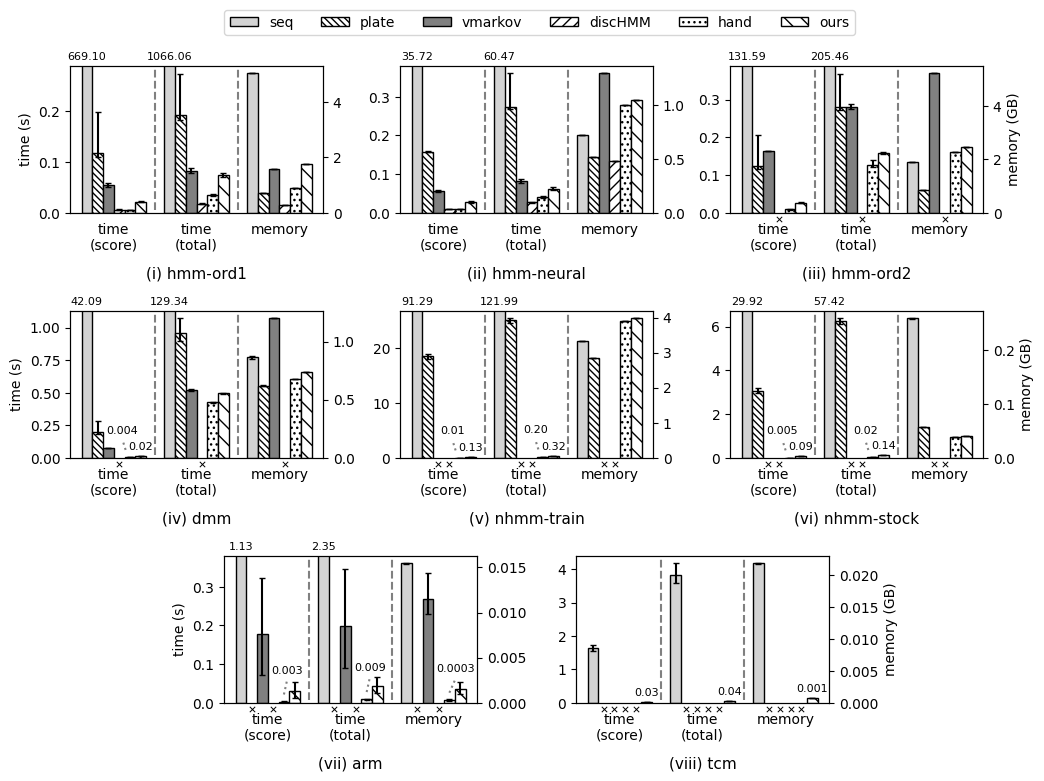

In [ ]:
import matplotlib.patches as mpatches
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

ylims_left = [0.29, 0.38, 0.39,
              1.13, 26.78, 6.72,
              0.38, 4.40]
            #   2.70, 4.40]

# ylims = [(0.0, 0.2882423661534117), (0.0, 0.3791961382392883), (0.0, 0.3866156763189697), (0.0, 1.130627699862671), (0.0, 26.7789922884668), (0.0, 6.715053216826172), (0.0, 2.702763038605957), (0.0, 4.395915659707031)]

ylims_right = [5.305343769599999, 1.3649956212479997, 5.5015523039232,
               1.2637056241152, 4.1963837723136, 0.2733114069504,
               0.0162884606976, 0.022982577408]


colors = {
    "seq": "lightgrey",
    "plate": "white",
    "vmarkov": "grey",
    "discHMM": "white",
    "manual": "white",
    "ours": "white",
}

patterns = {
    "seq": "",
    "plate": "\\\\\\\\\\",
    "vmarkov": "",
    "discHMM": "///",
    "manual": "...",
    "ours": "\\\\",
}

fig = plt.figure(figsize=(11, 7))

ax1 = fig.add_axes([0.05, 0.75, 0.23, 0.21])
ax2 = fig.add_axes([0.35, 0.75, 0.23, 0.21])
ax3 = fig.add_axes([0.65, 0.75, 0.23, 0.21])
ax4 = fig.add_axes([0.05, 0.40, 0.23, 0.21])
ax5 = fig.add_axes([0.35, 0.40, 0.23, 0.21])
ax6 = fig.add_axes([0.65, 0.40, 0.23, 0.21])
ax7 = fig.add_axes([0.19, 0.05, 0.23, 0.21])
ax8 = fig.add_axes([0.51, 0.05, 0.23, 0.21])
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

benchmarks = ["hmm-ord1", "hmm-neural", "hmm-ord2", "dmm", "nhmm-train", "nhmm-stock", "arm", "tcm"]
for k, benchmark in enumerate(benchmarks):
    df = pd.concat([time.loc[[benchmark]].stack(level=1).droplevel(0),
                    memory.loc[[benchmark]].set_index(pd.Index(["memory"]))], axis=0)
    df_low = pd.concat([time_low.loc[[benchmark]].stack(level=1).droplevel(0),
                        memory_low.loc[[benchmark]].set_index(pd.Index(["memory"]))], axis=0)
    df_high = pd.concat([time_high.loc[[benchmark]].stack(level=1).droplevel(0),
                         memory_high.loc[[benchmark]].set_index(pd.Index(["memory"]))], axis=0)

    df = df.reindex(columns=["seq", "plate", "vmarkov", "discHMM", "manual", "ours"])
    df_low = df_low.reindex(columns=["seq", "plate", "vmarkov", "discHMM", "manual", "ours"])
    df_high = df_high.reindex(columns=["seq", "plate", "vmarkov", "discHMM", "manual", "ours"])

    width = 0.13
    n_methods = len(df.columns) 
    offsets = np.linspace(-width*(n_methods-1)/2, width*(n_methods-1)/2, n_methods)
    groups = np.arange(len(df.index))
    ax_left = axes[k]
    ax_right = ax_left.twinx()
    ax_left.set_ylim(0, ylims_left[k])
    ax_right.set_ylim(0, ylims_right[k])

    for j, col in enumerate(df.columns):
        for i in [0, 1, 2]:
            ax = ax_left if i != 2 else ax_right
            
            if not np.isnan(df.iloc[i][col]):
                bars = ax.bar(groups[i] + offsets[j],
                              df.iloc[i][col],
                              yerr=[[max(0, df.iloc[i][col] - df_low.iloc[i][col])], [max(0, df_high.iloc[i][col] - df.iloc[i][col])]],
                              capsize=2,
                              width=width,
                              hatch=patterns[col],
                              facecolor=colors[col],
                              edgecolor="black",
                              label=col if i == 0 else None)

                if (i, col, benchmark) in {(0, "ours", "dmm"),
                                           (0, "ours", "nhmm-train"),
                                           (1, "ours", "nhmm-train"),
                                           (0, "ours", "nhmm-stock"),
                                           (1, "ours", "nhmm-stock"),
                                           (0, "ours", "tcm"),
                                           (1, "ours", "tcm"),
                                           (2, "ours", "tcm"),
                                        #    (0, "ours", "arm"),
                                        #    (1, "ours", "arm"),
                                           }:
                    for bar in bars:
                        height = bar.get_height()
                        x_offset = bar.get_x() + bar.get_width() * 0.5
                        ax.annotate(f"{height:.3f}" if height < 0.01 else f"{height:.2f}",
                                    xy=(x_offset, height),
                                    xytext=(0, 3),
                                    textcoords="offset points",
                                    ha='center', va='bottom', fontsize=8)
                
                # if (i, col, benchmark) in {(0, "discHMM", "hmm-ord1"),
                #                            (0, "discHMM", "hmm-neural")}:
                #     for bar in bars:
                #         height = bar.get_height()
                #         x_offset = bar.get_x() + bar.get_width() * 0.5
                #         line_start = [x_offset, height + ax.get_ylim()[1] * 0.05]
                #         line_end = [x_offset + bar.get_width() * 0.5, height + ax.get_ylim()[1] * 0.17]
                #         ax.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], color="grey", ls="dotted")
                #         ax.annotate(f"{height:.3f}" if height < 0.01 else f"{height:.2f}",
                #                     xy=line_end,
                #                     xytext=(0, 3),
                #                     textcoords="offset points",
                #                     ha='center', va='bottom', fontsize=8)

                if (i, col, benchmark) in {(0, "manual", "dmm"),
                                           (0, "manual", "nhmm-train"),
                                           (1, "manual", "nhmm-train"),
                                           (0, "manual", "nhmm-stock"),
                                           (1, "manual", "nhmm-stock"),}:

                    for bar in bars:
                        height = bar.get_height()
                        x_offset = bar.get_x() + bar.get_width() * 0.5
                        line_start = [x_offset - bar.get_width() * 0.4, height + ax.get_ylim()[1] * 0.05]
                        line_end = [x_offset - bar.get_width() * 0.7, height + ax.get_ylim()[1] * 0.12]
                        ax.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], color="grey", ls="dotted")
                        ax.annotate(f"{height:.3f}" if height < 0.01 else f"{height:.2f}",
                                    xy=line_end,
                                    xytext=(0, 3),
                                    textcoords="offset points",
                                    ha='center', va='bottom', fontsize=8)

                if (i, col, benchmark) in {(0, "manual", "arm"),
                                           (1, "manual", "arm"),
                                           (2, "manual", "arm"),}:
                    for bar in bars:
                        height = bar.get_height()
                        x_offset = bar.get_x() + bar.get_width() * 0.5
                        line_start = [x_offset - bar.get_width() * 0.0, height + ax.get_ylim()[1] * 0.05]
                        line_end = [x_offset + bar.get_width() * (0.6 if i == 2 else 0.3), height + ax.get_ylim()[1] * 0.15]
                        ax.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], color="grey", ls="dotted")
                        ax.annotate(f"{height:.4f}" if height < 0.001 else f"{height:.3f}",
                                    xy=line_end,
                                    xytext=(0, 3),
                                    textcoords="offset points",
                                    ha='center', va='bottom', fontsize=8)
                

                if col == "seq" and i < 2 and benchmark in {"hmm-ord1", "hmm-neural", "hmm-ord2", "dmm", "nhmm-train", "nhmm-stock", "arm"}:
                    for bar in bars:
                        height = bar.get_height()
                        x_offset = bar.get_x() + bar.get_width() * 0.5
                        ax.annotate(f"{height:.3f}" if height < 0.01 else f"{height:.2f}",
                                    xy=(x_offset, ylims_left[k]),
                                    xytext=(0, 3),
                                    textcoords="offset points",
                                    ha='center', va='bottom', fontsize=8)
                        
    for j, col in enumerate(df.columns):
        for i in [0, 1, 2]:
            ax = ax_left if i != 2 else ax_right
            if np.isnan(df.iloc[i][col]):
                ax.scatter(groups[i] + offsets[j], - ax.get_ylim()[1] * 0.04, color="black", marker="x", s=15, linewidth=0.7, clip_on=False)
                ax.set_ylim(0)

    ax_left.set_xticks(groups)
    ax_left.set_xticklabels(["time\n(score)", "time\n(total)", "memory"])

    if k % 3 == 0:
        ax_left.set_ylabel('time (s)')
    if k in [2, 5, 7]:
        ax_right.set_ylabel('memory (GB)')

    ax_left.set_title(f'({["i", "ii", "iii", "iv", "v", "vi", "vii", "viii"][k]}) {benchmark}', y=-0.5, fontsize=11)
    ax_left.xaxis.set_ticks_position("none")

    left_y_max = ax_left.get_ylim()[1]
    ax_left.vlines(1.5, left_y_max * 0.02, left_y_max * 0.98, ls="dashed", color="gray")
    ax_left.vlines(0.5, left_y_max * 0.02, left_y_max * 0.98, ls="dashed", color="gray")


methods = ["seq", "plate", "vmarkov", "discHMM", "manual", "ours"]
_methods = ["seq", "plate", "vmarkov", "discHMM", "hand", "ours"]
handles = [mpatches.Patch(facecolor=colors[label], edgecolor="black", hatch=patterns[label], label=label) for label in methods]
fig.legend(handles, _methods, bbox_to_anchor=(0.77, 1.05), ncol=6)

plt.show()
# plt.savefig("performance.pdf", bbox_inches="tight")